# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from joblib import dump,load

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../Threads-Review/threads_reviews.csv")

In [3]:
df.head()

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43


In [4]:
df.shape

(32910, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              32910 non-null  object
 1   review_description  32910 non-null  object
 2   rating              32910 non-null  int64 
 3   review_date         32910 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [6]:
df.describe()

,rating
count,32910.000000
mean,3.398481
std,1.751480
min,1.000000
25%,1.000000
50%,4.000000
75%,5.000000
max,5.000000


In [7]:
df['source'].value_counts()

Google Play    30270
App Store       2640
Name: source, dtype: int64

In [8]:
df['rating'].describe()

count    32910.000000
mean         3.398481
std          1.751480
min          1.000000
25%          1.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

In [9]:
df.isnull().sum()

source                0
review_description    0
rating                0
review_date           0
dtype: int64

In [10]:
df[df.duplicated]

,source,review_description,rating,review_date
31351,App Store,We will get together tomorrow,5,2023-07-21 07:33:34


In [11]:
# 1 row of duplicated data, it can be dropped

In [12]:
df = df.drop_duplicates()

# EDA

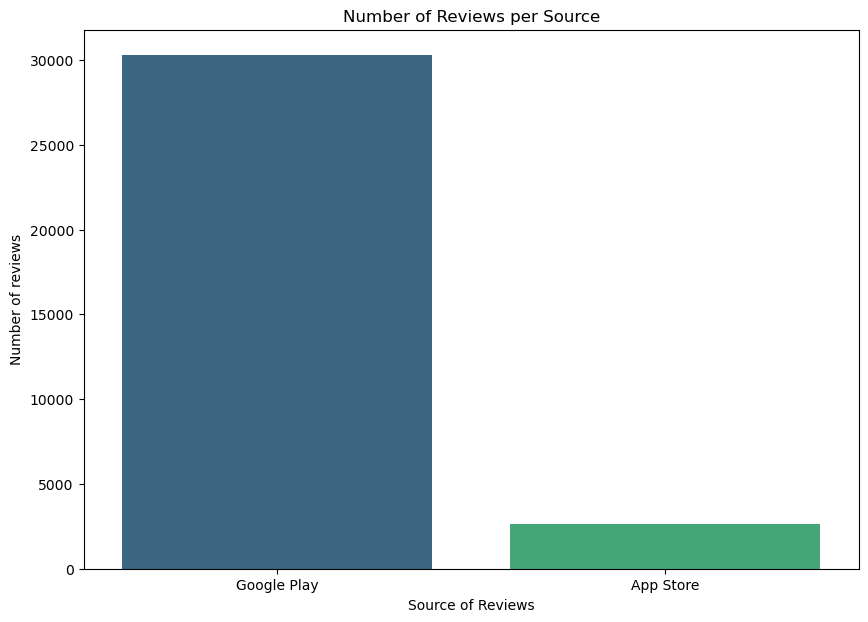

In [13]:
plt.figure(figsize=(10, 7))
sns.countplot(df, x='source', palette='viridis')
plt.xlabel('Source of Reviews')
plt.ylabel('Number of reviews')
plt.title('Number of Reviews per Source');

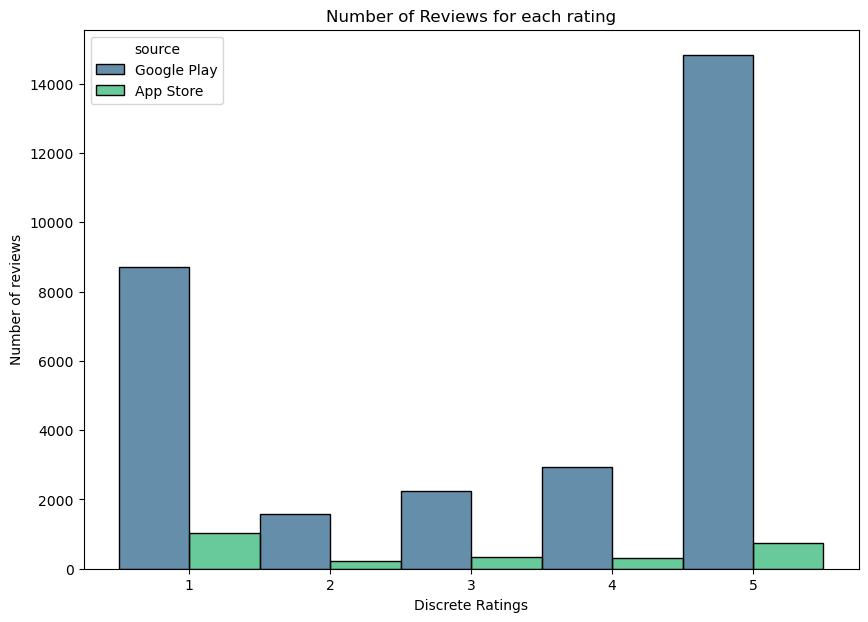

In [14]:
plt.figure(figsize=(10, 7))
sns.histplot(df, x='rating', hue='source', multiple='dodge', discrete=True, palette='viridis')
plt.xlabel('Discrete Ratings')
plt.ylabel('Number of reviews')
plt.title('Number of Reviews for each rating');

In [15]:
#Most reviews are from Google Playstore

In [16]:
df_feat = df
df_feat['review_date'] = pd.to_datetime(df_feat['review_date'])

df_feat['day'] = df_feat['review_date'].dt.day
df_feat['day_of_the_week'] = df_feat['review_date'].dt.day_name()
df_feat['week'] = df_feat['review_date'].dt.isocalendar().week
df_feat['month'] = df_feat['review_date'].dt.month_name()

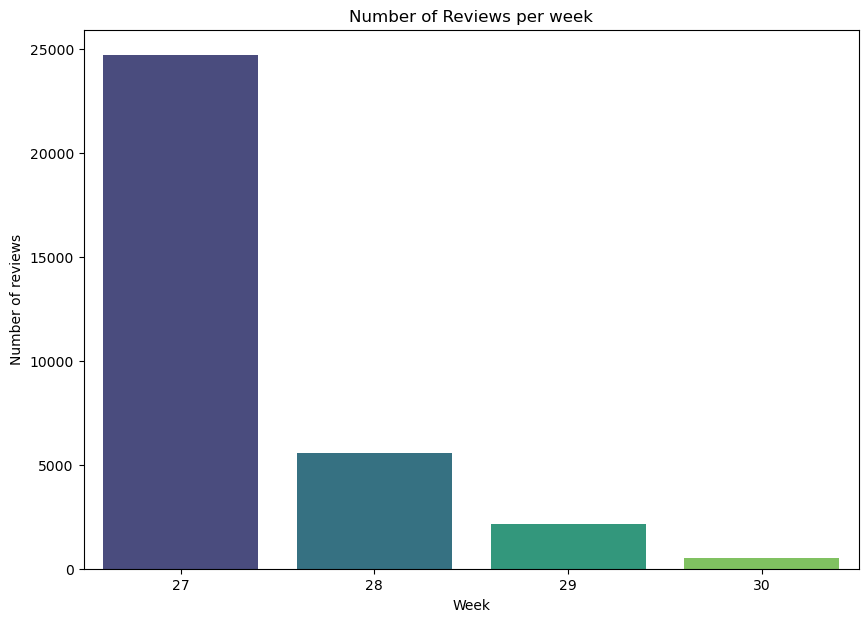

In [17]:
plt.figure(figsize=(10, 7))
sns.countplot(df_feat, x='week', palette='viridis')
plt.xlabel('Week')
plt.ylabel('Number of reviews')
plt.title('Number of Reviews per week');

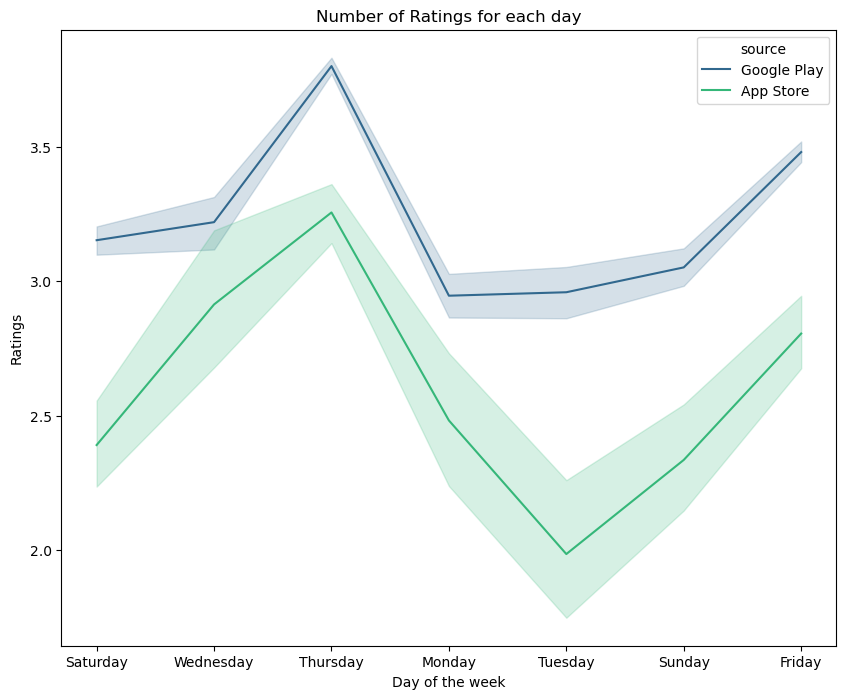

In [18]:
plt.figure(figsize=(10, 8))
sns.lineplot(x = df_feat['day_of_the_week'] , y = df_feat['rating'], hue=df_feat['source'], palette='viridis')
plt.xlabel('Day of the week')
plt.ylabel('Ratings')
plt.title('Number of Ratings for each day');

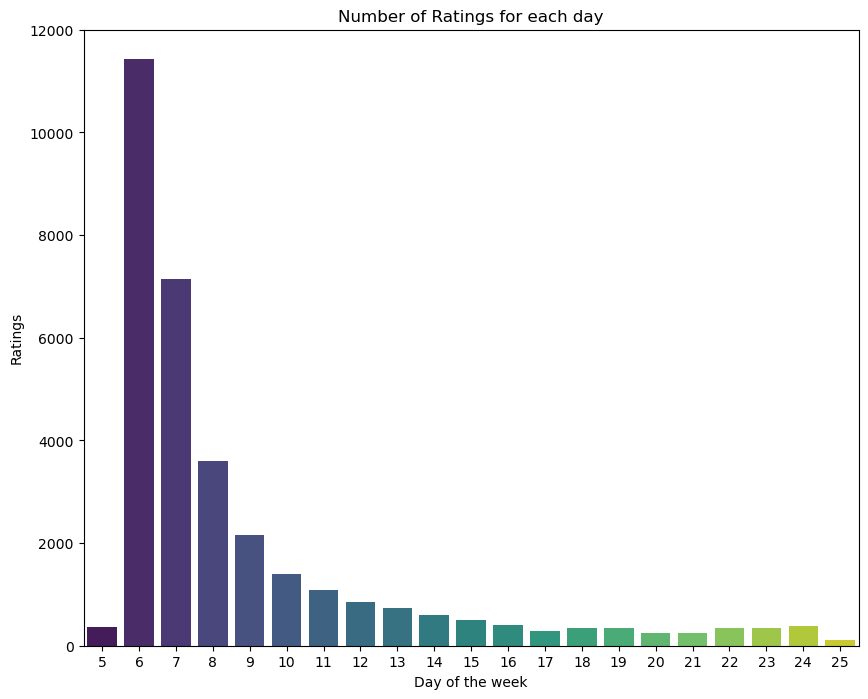

In [19]:
plt.figure(figsize=(10, 8))
sns.countplot(df_feat, x='day', palette='viridis')
plt.xlabel('Day of the week')
plt.ylabel('Ratings')
plt.title('Number of Ratings for each day');

## Sentiment Analysis and Pre Processing

In [20]:
def get_polarity(rating):
    if rating < 3:
        return -1
    elif rating == 3:
        return 0
    else:
        return 1
        

df_feat['polarity'] = df_feat['rating'].apply(get_polarity)

In [21]:
df_feat['polarity']

0       -1
1        0
2        0
3        0
4        0
        ..
32905   -1
32906   -1
32907   -1
32908   -1
32909   -1
Name: polarity, Length: 32909, dtype: int64

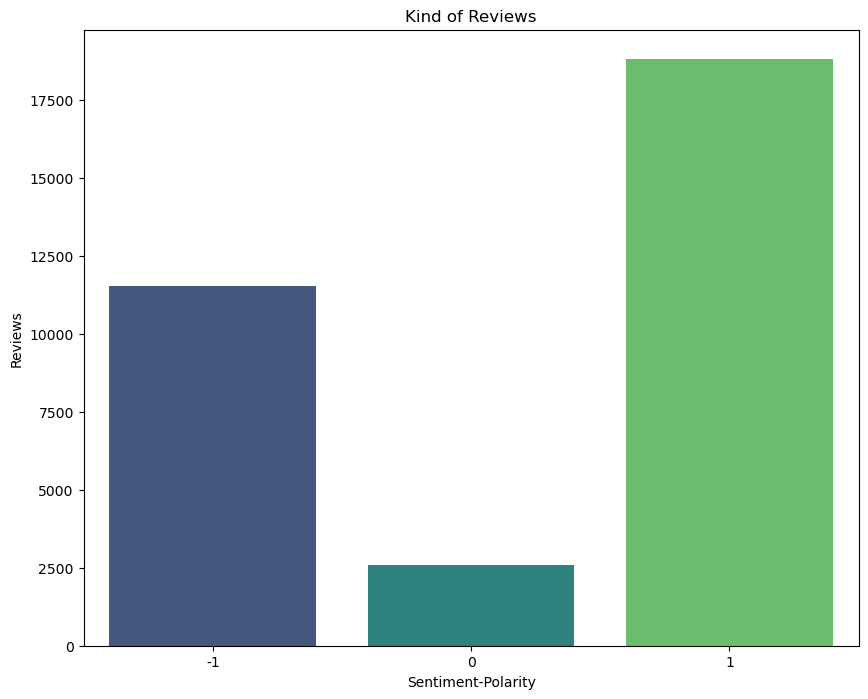

In [22]:
plt.figure(figsize=(10, 8))
sns.countplot(df_feat, x='polarity',palette='viridis')
plt.xlabel('Sentiment-Polarity')
plt.ylabel('Reviews')
plt.title('Kind of Reviews');

#### It should be obvious that 5 star rating means positive review and 1 star would be the negative review. However, the neutral count amongst 1 star and 5 star is about the same. What could be the reason for this?

In [23]:
frequency_df = pd.DataFrame(pd.Series(' '.join(df_feat['review_description']).split()).value_counts()).reset_index()
frequency_df.columns = ['words', 'frequency']

In [24]:
frequency_df.head(10)

,words,frequency
0,to,10563
1,I,9707
2,the,9190
3,app,8076
4,and,7565
5,is,6823
6,a,6740
7,it,5584
8,of,4734
9,this,4076


#### We can observe the frequency of stopwords is high

In [25]:
# Get rid of all stopwords, punctuations, and emojis
def pre_process(text):
    stop_words = stopwords.words('english')
    reviews_tokenized = word_tokenize(text.lower())
    reviews = [word for word in reviews_tokenized if word.isalpha() and word not in stop_words]
    return ' '.join(reviews)

df_feat['review_processed'] = df_feat['review_description'].apply(pre_process)

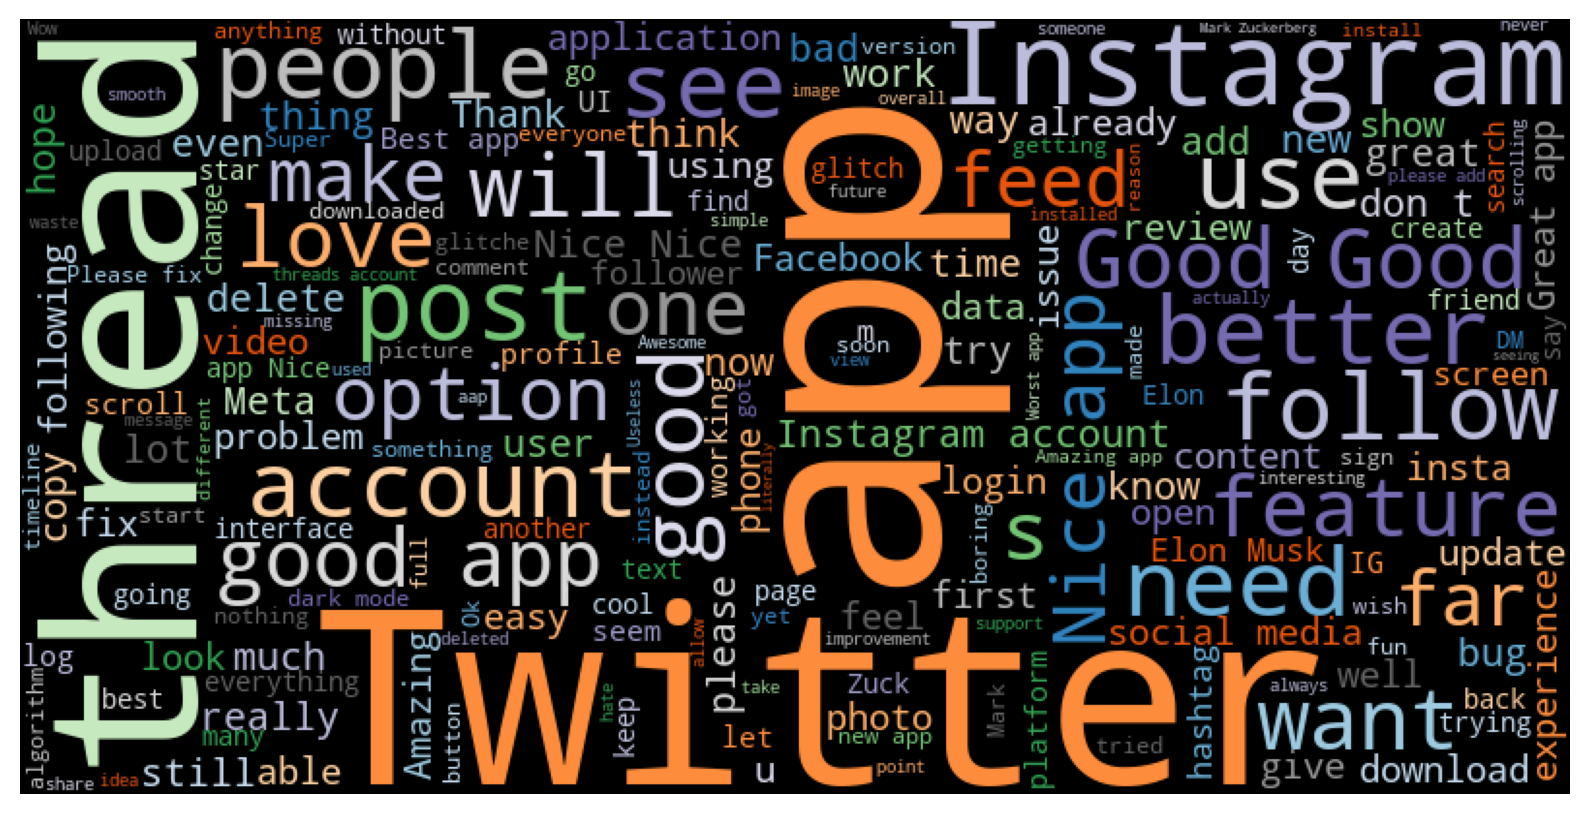

In [26]:
wordcloud = WordCloud(width=800, height=400, colormap='tab20c').generate((' '.join(df_feat['review_description'])))

plt.figure(figsize=(10, 10), dpi=200)
plt.imshow(wordcloud)
plt.axis('off');


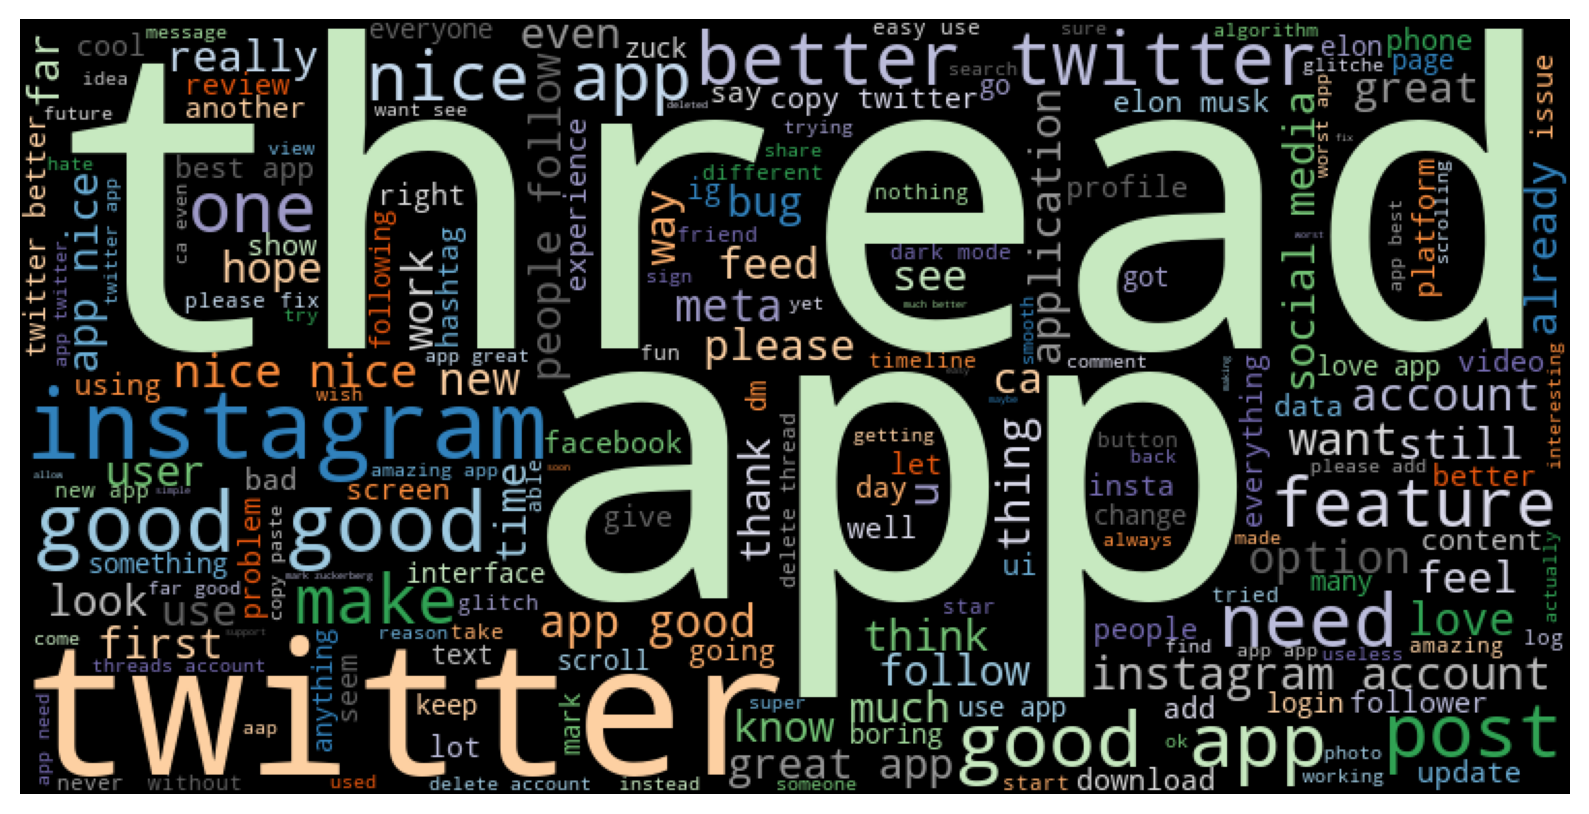

In [27]:
wordcloud = WordCloud(width=800, height=400, colormap='tab20c').generate((' '.join(df_feat['review_processed'])))

plt.figure(figsize=(10, 10), dpi=200)
plt.imshow(wordcloud)
plt.axis('off');

In [28]:
X = df_feat['review_processed']
y = df_feat['polarity']

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .3, random_state= 42)

In [30]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train, y_train)
X_test_tfidf = tfidf.transform(X_test)

In [31]:
def model(model):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    print(classification_report(y_test, y_pred))

#### Multinomial NB

              precision    recall  f1-score   support

          -1       0.78      0.74      0.76      3485
           0       0.00      0.00      0.00       753
           1       0.81      0.94      0.87      5635

    accuracy                           0.80      9873
   macro avg       0.53      0.56      0.54      9873
weighted avg       0.74      0.80      0.76      9873



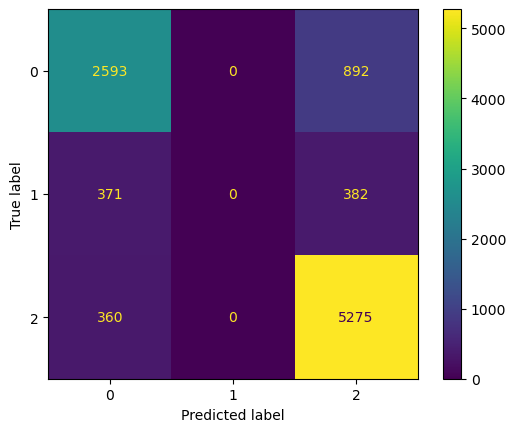

In [32]:
nb = MultinomialNB()
model(nb)

#### Ada boost classifier

              precision    recall  f1-score   support

          -1       0.78      0.48      0.60      3485
           0       0.29      0.05      0.08       753
           1       0.70      0.95      0.81      5635

    accuracy                           0.72      9873
   macro avg       0.59      0.49      0.50      9873
weighted avg       0.70      0.72      0.68      9873



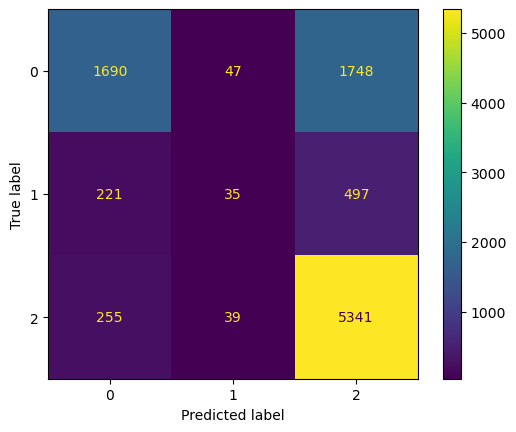

In [33]:
ada_mod = AdaBoostClassifier()
model(ada_mod)

#### Gradient Boosting

              precision    recall  f1-score   support

          -1       0.81      0.54      0.64      3485
           0       0.35      0.03      0.06       753
           1       0.72      0.96      0.82      5635

    accuracy                           0.74      9873
   macro avg       0.63      0.51      0.51      9873
weighted avg       0.72      0.74      0.70      9873



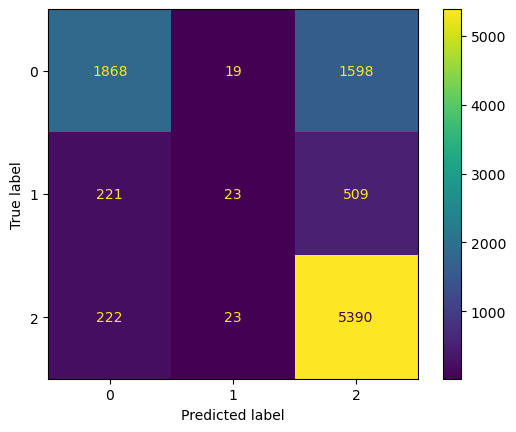

In [34]:
gradient_mod = GradientBoostingClassifier()
model(gradient_mod)

#### Logistic Regression

              precision    recall  f1-score   support

          -1       0.78      0.73      0.76      3485
           0       0.39      0.08      0.13       753
           1       0.81      0.92      0.86      5635

    accuracy                           0.79      9873
   macro avg       0.66      0.58      0.58      9873
weighted avg       0.77      0.79      0.77      9873



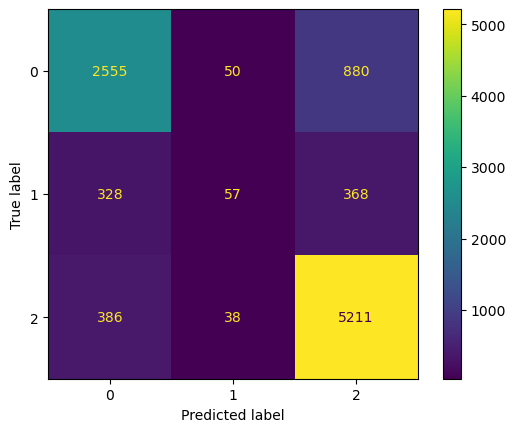

In [35]:
log_model = LogisticRegression(max_iter= 1000)
model(log_model)

In [36]:
# We will consider Logistic Regression model as our final model

In [37]:
dump(log_model, 'final_model.joblib')

['final_model.joblib']